**OBJECTIVE:** Recreate pictures and tables in the manuscript

In [1]:
import numpy as np
import pandas as pd
import igraph as ig

from modSAR.network_algorithms import ModSAR
from modSAR.cdk_utils import CDKUtils
from modSAR.dataset import QSARDatasetIO
from scripts.validation import DataSplit

from sklearn.externals import joblib

from plotnine import *
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

DATASETS = ['NYPR1', 'NYPR2', 'CHRM3', 'hDHFR', 'rDHFR']
ALGORITHMS = ['modsar', 'svm', 'rf', 'oplrareg']

qsar_datasets = \
{dataset_name:
    QSARDatasetIO.load(dataset_name=dataset_name, 
                       filepath='/mnt/data/%s.xlsx' % dataset_name, 
                       calculate_similarity=False)
 for dataset_name in DATASETS
}

In [3]:
qsar_datasets['NYPR1']

QSARDataset NYPR1 
 -- Samples : 363
 -- Features:  71

# Data Input and Preparation

In [2]:
# Read spreadsheets containing test results
dataset_results = []
for dataset_name in DATASETS:
    for algorithm in ALGORITHMS:
        for i in range(1, 5+1):
            dataset_results.append(pd.read_excel('/mnt/data/results/%s/results_%s_split%02d_alg_%s.xlsx' % 
                                                 (dataset_name, dataset_name, i, algorithm)))
dataset_results = pd.concat(dataset_results, sort=False)
dataset_results['dataset'] = pd.Categorical(dataset_results['dataset'], categories=DATASETS)

In [3]:
data_splits = {
    dataset_name: DataSplit(qsar_dataset, filename='/mnt/data/%s_splits.xlsx' % dataset_name)
    for dataset_name, qsar_dataset in qsar_datasets.items()}

In [5]:
# Read best regression models generated by the algorithm for each data split
best_models = \
{algorithm: {dataset_name :
    [joblib.load('/mnt/data/results/%s/%s_split%02d_alg_%s.joblib' % (dataset_name, dataset_name, i, algorithm)) 
     for i in range(1, 5+1)]
 for dataset_name in DATASETS
} for algorithm in ALGORITHMS}

# Tables

## Table 2 - Network characteristics

Statistics of networks created in every test

In [6]:
def get_network_stats(name, i, g):
    modules = pd.Series(g.vs['louvain']).value_counts()
    return pd.DataFrame({'dataset' : name, 
                         'data_split': i + 1,
                         'nodes': len(g.vs),
                         'density': g.density(),
                         'threshold': g['threshold'],
                         'ACC': g['globalClusteringCoefficient'],
                         'modularity': g.modularity(pd.Categorical(g.vs['louvain']).codes),
                         'number_main_modules': len(modules[modules != 1]),
                         'number_singletons': len(modules[modules == 1]),
                         'average_degree': np.mean(g.degree()),
                         'average_path_length': g.average_path_length(),
                         'degree_assortativity': g.assortativity_degree()},
                        index=[0])

network_stats = []

for dataset_name in DATASETS:
    for i in range(5):
        network_stats.append(get_network_stats(dataset_name, i, best_models['modsar'][dataset_name][i].instance_graph))

network_stats = pd.concat(network_stats)
network_stats['dataset'] = pd.Categorical(network_stats['dataset'], categories=qsar_datasets)

### Alternative 1: Ranges

In [7]:
int_cols = ['nodes', 'number_main_modules', 'number_singletons']

def value_ranges(data):
    stats = data.describe()
    features = stats.columns.tolist()
    return pd.Series({feat: '[%.2f - %.2f]' % (stats[feat].loc['min'], stats[feat].loc['max']) if feat not in int_cols 
                      else '[%d - %d]' % (stats[feat].loc['min'], stats[feat].loc['max']) for feat in features})

network_stats_range = network_stats.drop(columns=['data_split']).groupby(['dataset']).apply(value_ranges)
network_stats_range

,nodes,density,threshold,ACC,modularity,number_main_modules,number_singletons,average_degree,average_path_length,degree_assortativity
dataset,,,,,,,,,,
NYPR1,[247 - 248],[0.05 - 0.07],[0.24 - 0.28],[0.63 - 0.65],[0.77 - 0.81],[11 - 20],[23 - 57],[12.65 - 16.15],[1.64 - 4.95],[0.58 - 0.79]
NYPR2,[256 - 257],[0.11 - 0.14],[0.25 - 0.28],[0.68 - 0.73],[0.57 - 0.63],[7 - 14],[17 - 40],[29.41 - 35.30],[2.74 - 2.95],[0.78 - 0.91]
CHRM3,[434 - 436],[0.08 - 0.10],[0.30 - 0.31],[0.72 - 0.75],[0.54 - 0.62],[14 - 18],[20 - 28],[36.17 - 43.09],[3.52 - 4.19],[0.64 - 0.69]
hDHFR,[377 - 379],[0.10 - 0.10],[0.34 - 0.35],[0.73 - 0.76],[0.63 - 0.66],[11 - 12],[4 - 7],[36.52 - 39.22],[2.75 - 2.85],[0.46 - 0.53]
rDHFR,[596 - 597],[0.06 - 0.08],[0.37 - 0.40],[0.64 - 0.65],[0.63 - 0.69],[7 - 11],[1 - 3],[37.37 - 48.79],[2.70 - 3.06],[0.47 - 0.51]


In [8]:
# print(network_stats_range.to_latex())

### Alternative 2: Mean $\pm$ STD

In [9]:
def mean_std(data):
    stats = data.describe()
    features = stats.columns.tolist()
    return pd.Series({feat: '%.2f (\pm %.2f)$' % (stats[feat].loc['mean'], stats[feat].loc['std']) 
                      for feat in features})

network_stats_df = network_stats.drop(columns=['data_split']).groupby(['dataset']).apply(mean_std)
network_stats_df

,nodes,density,threshold,ACC,modularity,number_main_modules,number_singletons,average_degree,average_path_length,degree_assortativity
dataset,,,,,,,,,,
NYPR1,247.40 (\pm 0.55)$,0.06 (\pm 0.01)$,0.25 (\pm 0.02)$,0.64 (\pm 0.01)$,0.78 (\pm 0.02)$,13.60 (\pm 3.78)$,32.00 (\pm 14.28)$,15.16 (\pm 1.45)$,3.95 (\pm 1.32)$,0.67 (\pm 0.08)$
NYPR2,256.60 (\pm 0.55)$,0.13 (\pm 0.01)$,0.26 (\pm 0.01)$,0.69 (\pm 0.02)$,0.60 (\pm 0.03)$,10.40 (\pm 2.70)$,25.80 (\pm 9.83)$,31.97 (\pm 2.18)$,2.81 (\pm 0.09)$,0.83 (\pm 0.06)$
CHRM3,434.80 (\pm 0.84)$,0.09 (\pm 0.01)$,0.31 (\pm 0.00)$,0.73 (\pm 0.01)$,0.58 (\pm 0.04)$,16.60 (\pm 1.67)$,23.80 (\pm 3.03)$,40.18 (\pm 2.71)$,3.84 (\pm 0.30)$,0.67 (\pm 0.02)$
hDHFR,377.80 (\pm 0.84)$,0.10 (\pm 0.00)$,0.35 (\pm 0.01)$,0.75 (\pm 0.01)$,0.65 (\pm 0.01)$,11.40 (\pm 0.55)$,5.60 (\pm 1.34)$,37.55 (\pm 1.12)$,2.81 (\pm 0.05)$,0.49 (\pm 0.03)$
rDHFR,596.80 (\pm 0.45)$,0.08 (\pm 0.01)$,0.38 (\pm 0.01)$,0.64 (\pm 0.00)$,0.65 (\pm 0.02)$,8.40 (\pm 1.67)$,2.20 (\pm 0.84)$,44.80 (\pm 4.40)$,2.79 (\pm 0.15)$,0.50 (\pm 0.01)$


## Table S1 - Cross Validation Results

In [10]:
dataset_results.head()

,splitStrategy,splitNumber,dataset,datasetVersion,fold,algorithm,algorithm_version,internal,no_modules,no_classes,threshold,train_mae,test_mae,train_rmse,test_rmse,fit_time,beta,lambda,algorithmVersion,params,no_regions,no_features
0,1,1,NYPR1,default,1,modSAR,v0.1,True,40.0,60.0,0.24,0.105930,0.603444,0.356704,0.925563,51.595313,0.03,0.005,NaN,NaN,NaN,NaN
1,1,1,NYPR1,default,1,modSAR,v0.1,True,40.0,65.0,0.24,0.364761,0.794514,0.681562,1.160931,21.082392,0.03,0.050,NaN,NaN,NaN,NaN
2,1,1,NYPR1,default,1,modSAR,v0.1,True,40.0,49.0,0.24,0.550385,0.651250,0.909222,0.987716,8.814755,0.03,0.100,NaN,NaN,NaN,NaN
3,1,1,NYPR1,default,2,modSAR,v0.1,True,39.0,70.0,0.24,0.119399,0.862748,0.354709,1.399845,67.931351,0.03,0.005,NaN,NaN,NaN,NaN
4,1,1,NYPR1,default,2,modSAR,v0.1,True,39.0,74.0,0.24,0.326296,0.595404,0.601451,0.939482,59.158343,0.03,0.050,NaN,NaN,NaN,NaN


In [8]:
def internal_training_results(data, cols=['train_mae']):
    return pd.Series(
        {feat: '$%.2f (\pm %.2f)$' % (np.mean(data[feat]), np.std(data[feat])) 
                      for feat in cols}
    )

def median_MAE_results(data, cols=['train_mae']):
    return pd.Series(
        {feat: '$%.2f (\pm %.2f)$' % (np.median(data[feat]), np.median(abs(data[feat] - np.median(data[feat])))) 
                      for feat in cols}
    )

### Internal Training - MAE

In [26]:
training_df = \
    dataset_results.query('internal == True & algorithm == "modSAR"')\
    .groupby(['dataset', 'splitNumber']).apply(median_MAE_results)
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,train_mae,train_mae,train_mae,train_mae,train_mae
splitNumber,,,,,
1,$0.36 (\pm 0.17)$,$0.41 (\pm 0.13)$,$0.51 (\pm 0.06)$,$0.66 (\pm 0.09)$,$0.57 (\pm 0.09)$
2,$0.32 (\pm 0.17)$,$0.41 (\pm 0.08)$,$0.54 (\pm 0.06)$,$0.69 (\pm 0.10)$,$0.53 (\pm 0.11)$
3,$0.25 (\pm 0.08)$,$0.39 (\pm 0.10)$,$0.53 (\pm 0.05)$,$0.71 (\pm 0.07)$,$0.56 (\pm 0.10)$
4,$0.34 (\pm 0.14)$,$0.38 (\pm 0.12)$,$0.55 (\pm 0.09)$,$0.70 (\pm 0.06)$,$0.54 (\pm 0.07)$
5,$0.33 (\pm 0.16)$,$0.36 (\pm 0.06)$,$0.54 (\pm 0.05)$,$0.71 (\pm 0.06)$,$0.55 (\pm 0.09)$


In [27]:
print(training_df.to_latex())

\begin{tabular}{llllll}
\toprule
dataset &              NYPR1 &              NYPR2 &              CHRM3 &              hDHFR &              rDHFR \\
variable &          train\_mae &          train\_mae &          train\_mae &          train\_mae &          train\_mae \\
splitNumber &                    &                    &                    &                    &                    \\
\midrule
1           &  \$0.36 (\textbackslash pm 0.17)\$ &  \$0.41 (\textbackslash pm 0.13)\$ &  \$0.51 (\textbackslash pm 0.06)\$ &  \$0.66 (\textbackslash pm 0.09)\$ &  \$0.57 (\textbackslash pm 0.09)\$ \\
2           &  \$0.32 (\textbackslash pm 0.17)\$ &  \$0.41 (\textbackslash pm 0.08)\$ &  \$0.54 (\textbackslash pm 0.06)\$ &  \$0.69 (\textbackslash pm 0.10)\$ &  \$0.53 (\textbackslash pm 0.11)\$ \\
3           &  \$0.25 (\textbackslash pm 0.08)\$ &  \$0.39 (\textbackslash pm 0.10)\$ &  \$0.53 (\textbackslash pm 0.05)\$ &  \$0.71 (\textbackslash pm 0.07)\$ &  \$0.56 (\textbackslash pm 0.10)\$ \\


### Internal Validation - MAE

In [32]:
training_df = \
    dataset_results.query('internal == True & algorithm == "modSAR"')\
    .groupby(['dataset', 'splitNumber'])\
    .apply(lambda x: median_MAE_results(x, cols=['test_mae']))
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,test_mae,test_mae,test_mae,test_mae,test_mae
splitNumber,,,,,
1,$0.73 (\pm 0.11)$,$0.65 (\pm 0.11)$,$0.74 (\pm 0.06)$,$0.81 (\pm 0.07)$,$0.67 (\pm 0.06)$
2,$0.68 (\pm 0.11)$,$0.63 (\pm 0.10)$,$0.77 (\pm 0.08)$,$0.83 (\pm 0.06)$,$0.65 (\pm 0.06)$
3,$0.63 (\pm 0.05)$,$0.60 (\pm 0.08)$,$0.72 (\pm 0.07)$,$0.83 (\pm 0.07)$,$0.67 (\pm 0.06)$
4,$0.72 (\pm 0.12)$,$0.62 (\pm 0.08)$,$0.77 (\pm 0.07)$,$0.84 (\pm 0.07)$,$0.66 (\pm 0.07)$
5,$0.69 (\pm 0.12)$,$0.61 (\pm 0.08)$,$0.76 (\pm 0.08)$,$0.85 (\pm 0.07)$,$0.66 (\pm 0.06)$


In [33]:
print(training_df.to_latex())

\begin{tabular}{llllll}
\toprule
dataset &              NYPR1 &              NYPR2 &              CHRM3 &              hDHFR &              rDHFR \\
variable &           test\_mae &           test\_mae &           test\_mae &           test\_mae &           test\_mae \\
splitNumber &                    &                    &                    &                    &                    \\
\midrule
1           &  \$0.73 (\textbackslash pm 0.11)\$ &  \$0.65 (\textbackslash pm 0.11)\$ &  \$0.74 (\textbackslash pm 0.06)\$ &  \$0.81 (\textbackslash pm 0.07)\$ &  \$0.67 (\textbackslash pm 0.06)\$ \\
2           &  \$0.68 (\textbackslash pm 0.11)\$ &  \$0.63 (\textbackslash pm 0.10)\$ &  \$0.77 (\textbackslash pm 0.08)\$ &  \$0.83 (\textbackslash pm 0.06)\$ &  \$0.65 (\textbackslash pm 0.06)\$ \\
3           &  \$0.63 (\textbackslash pm 0.05)\$ &  \$0.60 (\textbackslash pm 0.08)\$ &  \$0.72 (\textbackslash pm 0.07)\$ &  \$0.83 (\textbackslash pm 0.07)\$ &  \$0.67 (\textbackslash pm 0.06)\$ \\


### Internal Training - RMSE

In [28]:
training_df = \
    dataset_results.query('internal == True & algorithm == "modSAR"')\
    .groupby(['dataset', 'splitNumber'])\
    .apply(lambda x: median_MAE_results(x, cols=['train_rmse']))
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,train_rmse,train_rmse,train_rmse,train_rmse,train_rmse
splitNumber,,,,,
1,$0.68 (\pm 0.21)$,$0.62 (\pm 0.17)$,$0.77 (\pm 0.05)$,$0.92 (\pm 0.07)$,$0.79 (\pm 0.09)$
2,$0.57 (\pm 0.29)$,$0.63 (\pm 0.09)$,$0.81 (\pm 0.05)$,$0.94 (\pm 0.08)$,$0.76 (\pm 0.11)$
3,$0.48 (\pm 0.24)$,$0.58 (\pm 0.14)$,$0.79 (\pm 0.04)$,$0.97 (\pm 0.03)$,$0.79 (\pm 0.09)$
4,$0.64 (\pm 0.20)$,$0.59 (\pm 0.16)$,$0.82 (\pm 0.08)$,$0.96 (\pm 0.03)$,$0.78 (\pm 0.07)$
5,$0.62 (\pm 0.22)$,$0.57 (\pm 0.05)$,$0.80 (\pm 0.06)$,$0.98 (\pm 0.03)$,$0.78 (\pm 0.08)$


In [29]:
print(training_df.to_latex())

\begin{tabular}{llllll}
\toprule
dataset &              NYPR1 &              NYPR2 &              CHRM3 &              hDHFR &              rDHFR \\
variable &         train\_rmse &         train\_rmse &         train\_rmse &         train\_rmse &         train\_rmse \\
splitNumber &                    &                    &                    &                    &                    \\
\midrule
1           &  \$0.68 (\textbackslash pm 0.21)\$ &  \$0.62 (\textbackslash pm 0.17)\$ &  \$0.77 (\textbackslash pm 0.05)\$ &  \$0.92 (\textbackslash pm 0.07)\$ &  \$0.79 (\textbackslash pm 0.09)\$ \\
2           &  \$0.57 (\textbackslash pm 0.29)\$ &  \$0.63 (\textbackslash pm 0.09)\$ &  \$0.81 (\textbackslash pm 0.05)\$ &  \$0.94 (\textbackslash pm 0.08)\$ &  \$0.76 (\textbackslash pm 0.11)\$ \\
3           &  \$0.48 (\textbackslash pm 0.24)\$ &  \$0.58 (\textbackslash pm 0.14)\$ &  \$0.79 (\textbackslash pm 0.04)\$ &  \$0.97 (\textbackslash pm 0.03)\$ &  \$0.79 (\textbackslash pm 0.09)\$ \\


### Internal Validation - RMSE

In [30]:
training_df = \
    dataset_results.query('internal == True & algorithm == "RandomForest"')\
    .groupby(['dataset', 'splitNumber'])\
    .apply(lambda x: median_MAE_results(x, cols=['test_rmse']))
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,test_rmse,test_rmse,test_rmse,test_rmse,test_rmse
splitNumber,,,,,
1,$0.75 (\pm 0.09)$,$0.64 (\pm 0.07)$,$0.89 (\pm 0.07)$,$0.86 (\pm 0.06)$,$0.78 (\pm 0.08)$
2,$0.72 (\pm 0.08)$,$0.63 (\pm 0.08)$,$0.92 (\pm 0.08)$,$0.86 (\pm 0.07)$,$0.78 (\pm 0.06)$
3,$0.71 (\pm 0.08)$,$0.63 (\pm 0.08)$,$0.87 (\pm 0.07)$,$0.89 (\pm 0.09)$,$0.78 (\pm 0.06)$
4,$0.73 (\pm 0.09)$,$0.67 (\pm 0.06)$,$0.90 (\pm 0.06)$,$0.89 (\pm 0.08)$,$0.78 (\pm 0.07)$
5,$0.74 (\pm 0.11)$,$0.61 (\pm 0.07)$,$0.88 (\pm 0.07)$,$0.87 (\pm 0.07)$,$0.80 (\pm 0.07)$


In [31]:
print(training_df.to_latex())

\begin{tabular}{llllll}
\toprule
dataset &              NYPR1 &              NYPR2 &              CHRM3 &              hDHFR &              rDHFR \\
variable &          test\_rmse &          test\_rmse &          test\_rmse &          test\_rmse &          test\_rmse \\
splitNumber &                    &                    &                    &                    &                    \\
\midrule
1           &  \$0.75 (\textbackslash pm 0.09)\$ &  \$0.64 (\textbackslash pm 0.07)\$ &  \$0.89 (\textbackslash pm 0.07)\$ &  \$0.86 (\textbackslash pm 0.06)\$ &  \$0.78 (\textbackslash pm 0.08)\$ \\
2           &  \$0.72 (\textbackslash pm 0.08)\$ &  \$0.63 (\textbackslash pm 0.08)\$ &  \$0.92 (\textbackslash pm 0.08)\$ &  \$0.86 (\textbackslash pm 0.07)\$ &  \$0.78 (\textbackslash pm 0.06)\$ \\
3           &  \$0.71 (\textbackslash pm 0.08)\$ &  \$0.63 (\textbackslash pm 0.08)\$ &  \$0.87 (\textbackslash pm 0.07)\$ &  \$0.89 (\textbackslash pm 0.09)\$ &  \$0.78 (\textbackslash pm 0.06)\$ \\


## Table 4 - External Set

In [19]:
def within_AD(sample_smiles, model):
    cdk_utils = CDKUtils()
    fp_sample = cdk_utils.calculate_fingerprint(sample_smiles)
    
    if model.fingerprints_training is None:
        print("Recalculating fingerprints for samples in the graph.")
        model.fingerprints_training = [cdk_utils.calculate_fingerprint(smiles)
                                       for smiles in model.instance_graph.vs['SMILES']]
    similarities = [cdk_utils.cdk.similarity.Tanimoto.calculate(fp_sample, fp_training)
                    for fp_training in model.fingerprints_training]
    similarities = np.array(similarities)
    
    neighbours = np.argwhere(similarities >= model.threshold).flatten()
    if len(neighbours) > 0:
        return True
    else:
        return False
    
    
def get_avg_performance(dataset_name, split_number):
    qsar_dataset = data_splits[dataset_name].qsar_dataset
    model = best_models['modsar'][dataset_name][split_number - 1]
    id_external_samples = data_splits[dataset_name].get_id_external_samples(split_number)
    
    is_within_ad = [within_AD(data_splits[dataset_name].qsar_dataset.X_smiles.loc[selected_ext_sample], model) 
                    for selected_ext_sample in id_external_samples]
    
    predictions = model.predict(qsar_dataset.X.loc[id_external_samples], 
                                qsar_dataset.X_smiles.loc[id_external_samples]) 
    abs_errors = abs(qsar_dataset.y.loc[id_external_samples].values.flatten() - predictions)
    
    result = pd.DataFrame({
        'dataset': dataset_name, 
        'split_number': split_number,
        'is_within_ad': is_within_ad,
        'abs_errors': abs_errors
    })
    return result



results = pd.concat([pd.concat([get_avg_performance(dataset_name, split_number) for split_number in range(1, 5+1)])
 for dataset_name in DATASETS])

Starting CDKBridge
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints for samples in the graph.
Recalculating fingerprints 

In [20]:
grouped_results = results.groupby(['dataset', 'split_number', 'is_within_ad'])\
    .apply(lambda x: pd.Series({'n': len(x), 
                                'feat': '$%.2f (\pm %.2f)$' % (np.mean(x['abs_errors']), np.std(x['abs_errors']))}))\
    .reset_index()

within_ad = grouped_results\
    .query('is_within_ad == True')\
    .pivot_table(values='feat', index='split_number',
                 columns=['dataset'], aggfunc='first')[DATASETS]
    
outside_ad = grouped_results\
    .query('is_within_ad == False')\
    .pivot_table(values='feat', index='split_number',
                 columns=['dataset'], aggfunc='first')[DATASETS]

In [21]:
within_ad

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
split_number,,,,,
1,$0.64 (\pm 0.63)$,$0.46 (\pm 0.42)$,$0.69 (\pm 0.55)$,$0.78 (\pm 0.62)$,$0.56 (\pm 0.53)$
2,$0.60 (\pm 0.71)$,$0.48 (\pm 0.37)$,$0.63 (\pm 0.54)$,$0.78 (\pm 0.81)$,$0.58 (\pm 0.52)$
3,$0.56 (\pm 0.60)$,$0.62 (\pm 0.60)$,$0.65 (\pm 0.57)$,$0.69 (\pm 0.71)$,$0.54 (\pm 0.56)$
4,$0.55 (\pm 0.62)$,$0.56 (\pm 0.50)$,$0.63 (\pm 0.59)$,$0.71 (\pm 0.62)$,$0.58 (\pm 0.60)$
5,$0.74 (\pm 0.80)$,$0.62 (\pm 0.54)$,$0.61 (\pm 0.56)$,$0.73 (\pm 0.60)$,$0.57 (\pm 0.55)$


In [22]:
print(within_ad.to_latex())

\begin{tabular}{llllll}
\toprule
dataset &              NYPR1 &              NYPR2 &              CHRM3 &              hDHFR &              rDHFR \\
split\_number &                    &                    &                    &                    &                    \\
\midrule
1            &  \$0.64 (\textbackslash pm 0.63)\$ &  \$0.46 (\textbackslash pm 0.42)\$ &  \$0.69 (\textbackslash pm 0.55)\$ &  \$0.78 (\textbackslash pm 0.62)\$ &  \$0.56 (\textbackslash pm 0.53)\$ \\
2            &  \$0.60 (\textbackslash pm 0.71)\$ &  \$0.48 (\textbackslash pm 0.37)\$ &  \$0.63 (\textbackslash pm 0.54)\$ &  \$0.78 (\textbackslash pm 0.81)\$ &  \$0.58 (\textbackslash pm 0.52)\$ \\
3            &  \$0.56 (\textbackslash pm 0.60)\$ &  \$0.62 (\textbackslash pm 0.60)\$ &  \$0.65 (\textbackslash pm 0.57)\$ &  \$0.69 (\textbackslash pm 0.71)\$ &  \$0.54 (\textbackslash pm 0.56)\$ \\
4            &  \$0.55 (\textbackslash pm 0.62)\$ &  \$0.56 (\textbackslash pm 0.50)\$ &  \$0.63 (\textbackslash pm 0

In [23]:
outside_ad

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
split_number,,,,,
1,$0.50 (\pm 0.58)$,$0.25 (\pm 0.26)$,$0.62 (\pm 0.48)$,$0.45 (\pm 0.00)$,NaN
2,$0.38 (\pm 0.52)$,$0.70 (\pm 0.32)$,$1.94 (\pm 0.78)$,$3.20 (\pm 0.99)$,NaN
3,$0.17 (\pm 0.12)$,$0.39 (\pm 0.39)$,$1.32 (\pm 1.18)$,$0.71 (\pm 0.49)$,NaN
4,$0.27 (\pm 0.20)$,$0.78 (\pm 1.41)$,$1.08 (\pm 1.02)$,$0.45 (\pm 0.00)$,$0.92 (\pm 0.68)$
5,$0.60 (\pm 0.76)$,$0.54 (\pm 0.68)$,$1.30 (\pm 0.92)$,$1.20 (\pm 0.75)$,$0.58 (\pm 0.00)$


In [24]:
print(outside_ad.to_latex())

\begin{tabular}{llllll}
\toprule
dataset &              NYPR1 &              NYPR2 &              CHRM3 &              hDHFR &              rDHFR \\
split\_number &                    &                    &                    &                    &                    \\
\midrule
1            &  \$0.50 (\textbackslash pm 0.58)\$ &  \$0.25 (\textbackslash pm 0.26)\$ &  \$0.62 (\textbackslash pm 0.48)\$ &  \$0.45 (\textbackslash pm 0.00)\$ &                NaN \\
2            &  \$0.38 (\textbackslash pm 0.52)\$ &  \$0.70 (\textbackslash pm 0.32)\$ &  \$1.94 (\textbackslash pm 0.78)\$ &  \$3.20 (\textbackslash pm 0.99)\$ &                NaN \\
3            &  \$0.17 (\textbackslash pm 0.12)\$ &  \$0.39 (\textbackslash pm 0.39)\$ &  \$1.32 (\textbackslash pm 1.18)\$ &  \$0.71 (\textbackslash pm 0.49)\$ &                NaN \\
4            &  \$0.27 (\textbackslash pm 0.20)\$ &  \$0.78 (\textbackslash pm 1.41)\$ &  \$1.08 (\textbackslash pm 1.02)\$ &  \$0.45 (\textbackslash pm 0.00)\$ &  \

## Comparison to a baseline model

For the sake of comparison, we can imagine a sort of null model for modSAR where test samples allocated to a group (module or a region) are predicted by the average of samples in the training group.

In [8]:
dataset_name = 'NYPR1'
split_number = 1

model = best_models['modsar'][dataset_name][(split_number - 1)]
class_names = model.class_names

fold_number = \
    dataset_results[(dataset_results['splitNumber'] == split_number) & 
                    (dataset_results['dataset'] == dataset_name) & 
                    (dataset_results['internal'] == False) & 
                    (dataset_results['algorithm'] == 'modSAR')]['fold'].iloc[0]
    
id_training_samples = data_splits[dataset_name].get_id_internal_tr_samples(split_number,fold_number)
id_testing_samples = data_splits[dataset_name].get_id_internal_ts_samples(split_number,fold_number)
id_external_set_samples = data_splits[dataset_name].get_id_external_samples(split_number)

all_y = data_splits[dataset_name].qsar_dataset.y
all_X = data_splits[dataset_name].qsar_dataset.X
all_X_smiles = data_splits[dataset_name].qsar_dataset.X_smiles

# Obtain data on training samples
training_classes = pd.Series([v['louvain'] for v in model.instance_graph.vs], 
                             name='module', index=id_training_samples)
training_y = all_y.loc[id_training_samples]
training_str = pd.DataFrame({'set': ['train'] * len(id_training_samples),
                             'dataset_name': [dataset_name] * len(id_training_samples),
                             'split_number': [split_number] * len(id_training_samples)}, index=id_training_samples)
training_df = pd.concat([training_classes, training_y, training_str], axis=1)

def get_oplra_region(model, data):
    module = data['module'].unique()[0]
    X = all_X.loc[data.index]
    
    oplra_model = model.models[module].final_model
    fStar = oplra_model.fStar
    if fStar:
        regions = oplra_model.get_regions(X.ix[:, fStar])
    else:
        regions = [0] * len(X)
    regions = pd.Series(regions, name='region', index=X.index)
    return pd.concat([data, regions], axis=1)

training_df = pd.concat([get_oplra_region(model, data) for module, data in training_df.groupby('module')])

# Calculate average pIC50s accross modules in training samples
module_avg = training_df.groupby(['module'])\
    .apply(lambda x: pd.Series({'avg_module_prediction': np.mean(x['pchembl_value'])}))
    
# Calculate average pIC50s accross modules in training samples
region_avg = training_df.groupby(['module', 'region'])\
    .apply(lambda x: pd.Series({'avg_region_prediction': np.mean(x['pchembl_value'])}))
    
# Obtain testing data
testing_classes = pd.Series([model.classify_sample(sample) for sample in all_X_smiles.loc[id_testing_samples]],
                            index=id_testing_samples, name='module')
testing_y = all_y.loc[id_testing_samples]
testing_str = pd.DataFrame({'set': ['internal_validation'] * len(id_testing_samples),
                            'dataset_name': [dataset_name] * len(id_testing_samples),
                            'split_number': [split_number] * len(id_testing_samples)}, index=id_testing_samples)
testing_df = pd.concat([testing_classes, testing_y, testing_str], axis=1)
testing_df = pd.concat([get_oplra_region(model, data) for module, data in testing_df.groupby('module')])

# Obtain external set 
external_set_classes = pd.Series([model.classify_sample(sample) for sample in all_X_smiles.loc[id_external_set_samples]],
                            index=id_external_set_samples, name='module')
external_set_y = all_y.loc[id_external_set_samples]
external_set_str = pd.DataFrame({'set': ['external_set'] * len(id_external_set_samples),
                             'dataset_name': [dataset_name] * len(id_external_set_samples),
                             'split_number': [split_number] * len(id_external_set_samples)}, index=id_external_set_samples)
external_set_df = pd.concat([external_set_classes, external_set_y, external_set_str], axis=1)
external_set_df = pd.concat([get_oplra_region(model, data) for module, data in external_set_df.groupby('module')])

# Combine results from all sets
all_sets = pd.concat([training_df, testing_df, external_set_df])
all_predictions = pd.DataFrame({'modSAR_prediction': model.predict(all_X, all_X_smiles)}, index=all_X.index)
all_sets = \
    all_sets.reset_index()\
    .merge(module_avg.reset_index())\
    .merge(region_avg.reset_index()).set_index(['index'])\
    .merge(all_predictions, left_index=True, right_index=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [9]:
all_sets['avg_module_error'] = abs(all_sets['pchembl_value'] - all_sets['avg_module_prediction'])
all_sets['avg_region_error'] = abs(all_sets['pchembl_value'] - all_sets['avg_region_prediction'])
all_sets['modSAR_error'] = abs(all_sets['pchembl_value'] - all_sets['modSAR_prediction'])
all_sets.sample(5)

,module,pchembl_value,set,dataset_name,split_number,region,avg_module_prediction,avg_region_prediction,modSAR_prediction,avg_module_error,avg_region_error,modSAR_error
CHEMBL1585652,m35,5.04,train,NYPR1,1,1,5.034706,5.212000,5.040000,0.005294,0.172000,7.993606e-15
CHEMBL413612,m33,6.12,train,NYPR1,1,2,6.672600,6.367500,6.062526,0.552600,0.247500,5.747384e-02
CHEMBL163470,m27,5.07,train,NYPR1,1,0,4.907500,4.942857,5.070000,0.162500,0.127143,0.000000e+00
CHEMBL189548,m30,7.41,train,NYPR1,1,2,7.674286,7.732917,7.586519,0.264286,0.322917,1.765194e-01
CHEMBL567719,m41,9.16,train,NYPR1,1,1,7.386579,8.400000,9.160000,1.773421,0.760000,2.486900e-14


In [10]:
all_sets[all_sets['set'] != "train"].groupby(['dataset_name', 'split_number', 'set'])\
    .apply(lambda x: pd.Series({'avg_module_MAE': x['avg_module_error'].mean(),
                                'avg_region_MAE': x['avg_region_error'].mean(),
                                'modSAR_MAE': x['modSAR_error'].mean()}))

avg_module_MAE     ...      modSAR_MAE
dataset_name split_number set                                     ...                
NYPR1        1            external_set               0.760193     ...        0.591594
                          internal_validation        0.544931     ...        0.334651

[2 rows x 3 columns]

# Figures

## Error Distribution - Figures 5 to 7

In [7]:
def get_external_predictions(algorithm, dataset_name, split_number, data_splits, models):
    alg = models[algorithm][dataset_name][split_number - 1]
    data_split = data_splits[dataset_name]
    
    idx = data_split.get_id_external_samples(split_number)
    
    X = data_split.qsar_dataset.X.loc[idx]
    if alg.algorithm_name.lower() == 'modsar':
        X_smiles = data_split.qsar_dataset.X_smiles.loc[idx]
    y = data_split.get_external_Y(split_number)
    
    if alg.algorithm_name.lower() == 'modsar':
        y_pred = pd.Series(alg.predict(X, X_smiles))
    else:
        y_pred = pd.Series(alg.predict(X))
    y_pred.index = y.index.values
    y_pred.name = 'predicted'
    
    split_number = pd.DataFrame({'dataset': data_split.qsar_dataset.name, 
                                 'algorithm': algorithm,
                                 'split_number': [1] * len(y_pred)}, index=y.index.values)
    
    return pd.concat([split_number, y, y_pred], axis=1)

In [8]:
# Calculate predictions for each sample in the external sets
external_predictions = []
for algorithm in ALGORITHMS:
    for dataset_name in DATASETS:
        for i in range(1, 5+1):
            print("Dataset : %s Split %02d Algorithm %s" % (dataset_name, i, algorithm))
            external_predictions.append(get_external_predictions(algorithm, dataset_name, i, data_splits, best_models))
        

external_predictions = pd.concat(external_predictions)
external_predictions['absolute_error'] = abs(external_predictions['pchembl_value'] - external_predictions['predicted'])

Dataset : NYPR1 Split 01 Algorithm modsar
Starting CDKBridge
Recalculating fingerprints for samples in the graph.
Dataset : NYPR1 Split 02 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR1 Split 03 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR1 Split 04 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR1 Split 05 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR2 Split 01 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR2 Split 02 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR2 Split 03 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR2 Split 04 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR2 Split 05 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : CHRM3 Split 01 Algori

In [9]:
def get_absolute_error_stats(data):
    stats = data['absolute_error'].describe()
    return pd.Series({
        '25%': stats['25%'],
        '50%': stats['50%'],
        '75%': stats['75%'],
        'label': "median = %.2f\nQ1 = %.2f\nQ3 = %.2f" % (stats['50%'], stats['25%'], stats['75%'])})
    
external_abs_stats = external_predictions.groupby(['dataset', 'algorithm']).apply(get_absolute_error_stats)
external_abs_stats.reset_index()

,dataset,algorithm,25%,50%,75%,label
0,CHRM3,modsar,0.208276,0.500000,0.977353,median = 0.50\nQ1 = 0.21\nQ3 = 0.98
1,CHRM3,oplrareg,0.296553,0.609452,1.039754,median = 0.61\nQ1 = 0.30\nQ3 = 1.04
2,CHRM3,rf,0.227775,0.532300,0.941000,median = 0.53\nQ1 = 0.23\nQ3 = 0.94
3,CHRM3,svm,0.417608,0.821423,1.277250,median = 0.82\nQ1 = 0.42\nQ3 = 1.28
4,NYPR1,modsar,0.139728,0.335000,0.772500,median = 0.33\nQ1 = 0.14\nQ3 = 0.77
5,NYPR1,oplrareg,0.135436,0.376220,0.880355,median = 0.38\nQ1 = 0.14\nQ3 = 0.88
6,NYPR1,rf,0.140750,0.349500,0.688500,median = 0.35\nQ1 = 0.14\nQ3 = 0.69
7,NYPR1,svm,0.223403,0.540206,1.164112,median = 0.54\nQ1 = 0.22\nQ3 = 1.16
8,NYPR2,modsar,0.190000,0.420105,0.712500,median = 0.42\nQ1 = 0.19\nQ3 = 0.71
9,NYPR2,oplrareg,0.262803,0.460766,0.788341,median = 0.46\nQ1 = 0.26\nQ3 = 0.79


In [30]:
external_predictions.query('algorithm == "modsar"').shape

(3500, 6)

In [20]:
algorithm_names = {
    'oplrareg': 'OPLRAreg',
    'modsar': 'modSAR',
    'rf': 'Random Forest',
    'svm': 'SVM Radial'
}

def plot_error_distribution(dataset, 
                            external_predictions=external_predictions, 
                            external_abs_stats=external_abs_stats,
                            y_pos=40, x_pos=1.25):
    plot_df = external_predictions.query('dataset == "%s"' % dataset).copy()
    plot2_df = external_abs_stats.reset_index().query('dataset == "%s"' % dataset).copy()

    plot_df['algorithm'] = plot_df['algorithm'].apply(lambda x: algorithm_names[x])
    plot2_df['algorithm'] = plot2_df['algorithm'].apply(lambda x: algorithm_names[x])

    
    g = (
      ggplot(plot_df) + 
        geom_histogram(aes(x="absolute_error"), alpha=0.9, color='white', fill='#ADADAD', 
                       binwidth = 0.05, size=0.1) + 
        geom_rect(data=plot2_df, mapping=aes(fill='algorithm', xmin='25%', xmax='75%', ymin=0, ymax=y_pos), 
                  alpha=0.4) + 
        geom_segment(data=plot2_df, mapping=aes(color='algorithm', yend='50%', x='50%', xend='50%'),  y=y_pos, size=1.3) +
        geom_text(data=plot2_df, mapping=aes(label='label', color='algorithm'), x=x_pos, y=y_pos*0.8, size=10) + 
        theme_bw() + xlab("Distribution of Absolute Error") + ylab("") +
        facet_grid("algorithm ~ .") + 
        scale_fill_discrete(guide=False) +
        scale_color_discrete(guide=False) + 
        theme(figure_size=(8, 6))
    )
    return g

### Dataset NPYR1

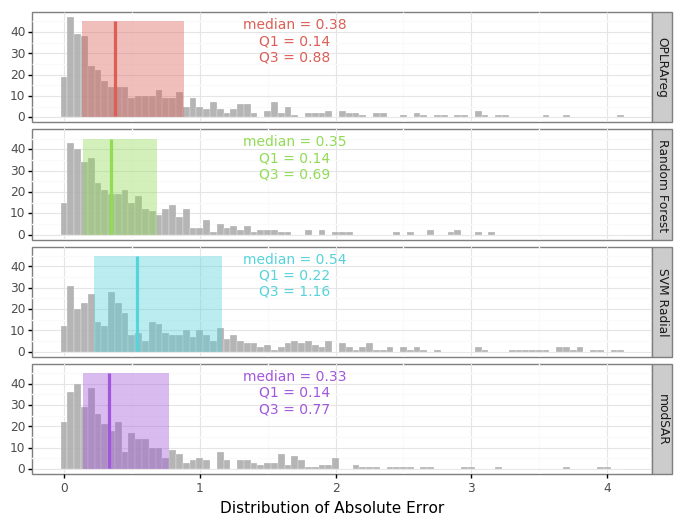

<ggplot: (8760475497613)>

In [21]:
plot_error_distribution('NYPR1', y_pos=45, x_pos=1.7)

### Dataset NPYR2

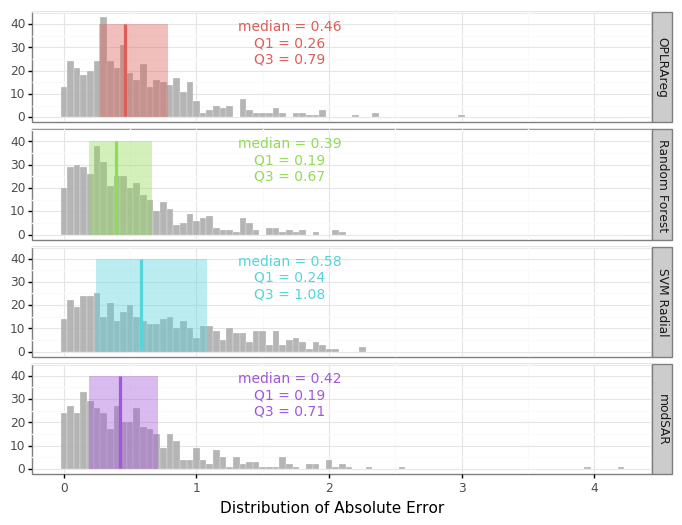

<ggplot: (-9223363276379415324)>

In [22]:
plot_error_distribution('NYPR2', x_pos=1.7)

### Dataset CHRM3

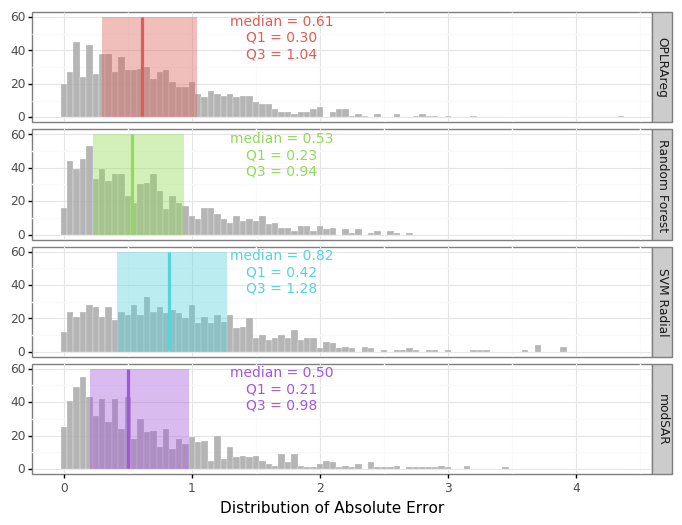

<ggplot: (8760470680931)>

In [31]:
plot_error_distribution('CHRM3', y_pos=60, x_pos=1.7)

### Dataset hDHFR

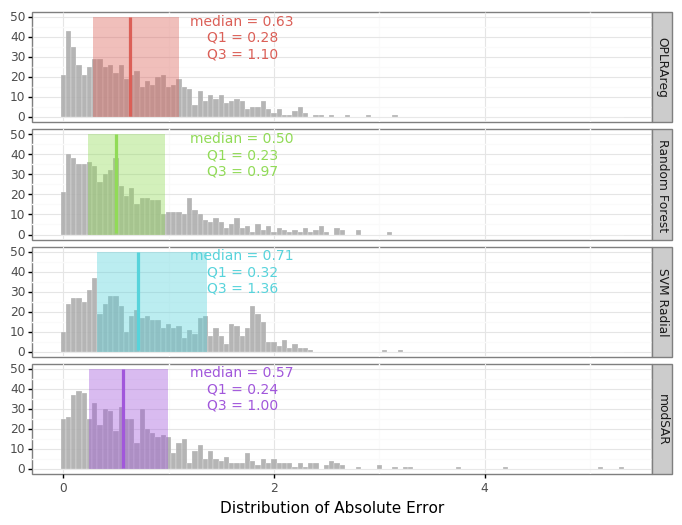

<ggplot: (8760470642731)>

In [32]:
plot_error_distribution('hDHFR', x_pos=1.7, y_pos=50)

### Dataset rDHFR

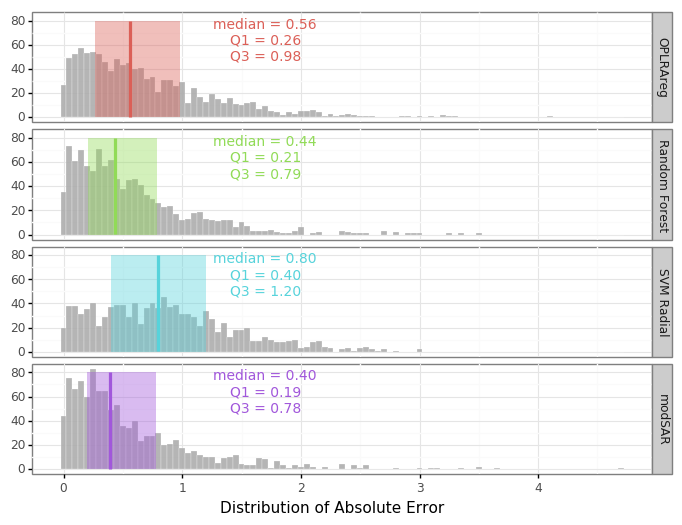

<ggplot: (8760470536235)>

In [33]:
plot_error_distribution('rDHFR', x_pos=1.7, y_pos=80)